## Домашнее задание № 4

##### [Исследуемый временной ряд](https://stat.yandex.ru/Russia/Images?view=table) — Яндекс.Картинки

## Пономарева Алиса ИАД-3

In [2]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\AliceP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [81]:
df = pd.read_csv('Images_Russia.csv', sep=';', index_col=['Date'], parse_dates=['Date'], dayfirst=True, error_bad_lines=False)

In [82]:
df.head()

,Monthly share,Monthly audience,Daily share,Daily audience
Date,,,,
2008-05-01,0.358822,6608910,0.063062,717430
2008-06-01,0.343537,6362910,0.061683,679620
2008-07-01,0.338905,6423440,0.061941,665290
2008-08-01,0.331003,6273210,0.062115,698350
2008-09-01,0.357767,7038170,0.062747,801190


In [83]:
df.rename(columns={'Monthly audience': 'month_aud'}, inplace=True)

In [85]:
df.tail()

,Monthly share,month_aud,Daily share,Daily audience
Date,,,,
2017-06-01,0.482919,28223040,0.110992,4336320
2017-07-01,0.471470,27154720,0.107642,3917590
2017-08-01,0.471237,27223970,0.111626,4116350
2017-09-01,0.495973,28496760,0.122149,4714080
2017-10-01,0.524024,29544750,0.130798,5157230


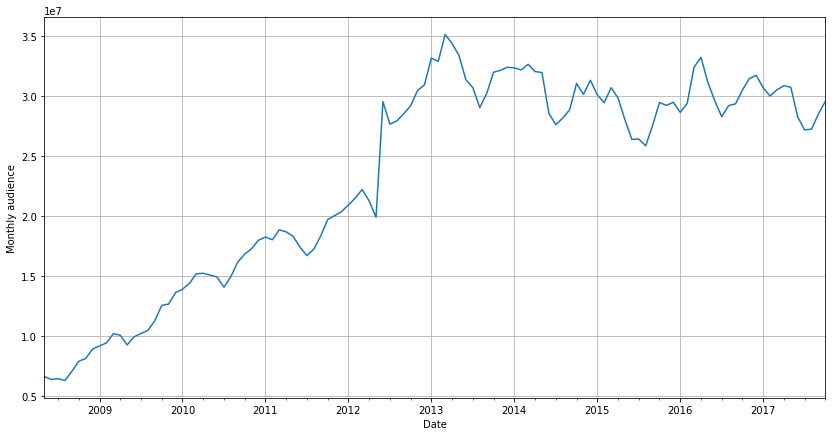

In [86]:
figsize(14,7)
df.month_aud.plot()
plt.ylabel('Monthly audience')
plt.grid('on')

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.366561


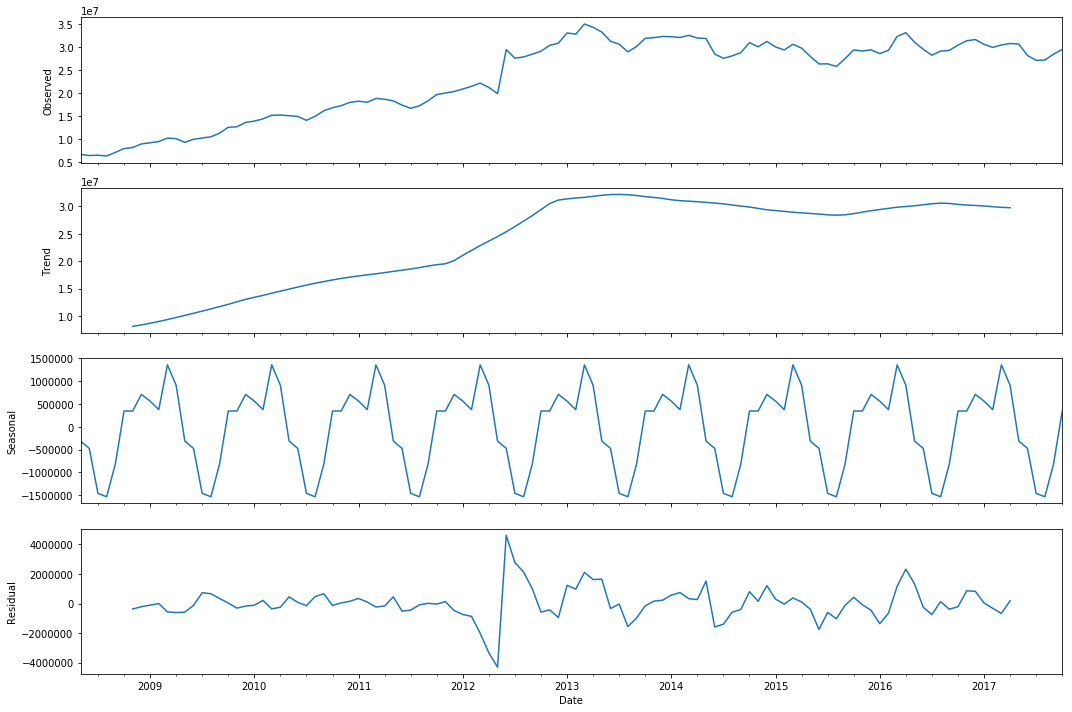

In [87]:
figsize(15,10)
sm.tsa.seasonal_decompose(df.month_aud).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.month_aud)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 1.529195
Критерий Дики-Фуллера: p=0.471849


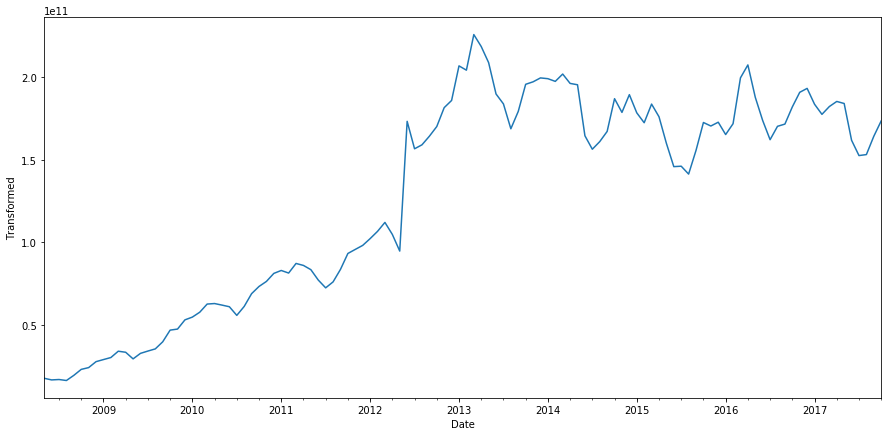

In [88]:
df['aud_box'], lmbda = stats.boxcox(df.month_aud)
figsize(15,7)
df.aud_box.plot()
plt.ylabel(u'Transformed')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.aud_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.359863


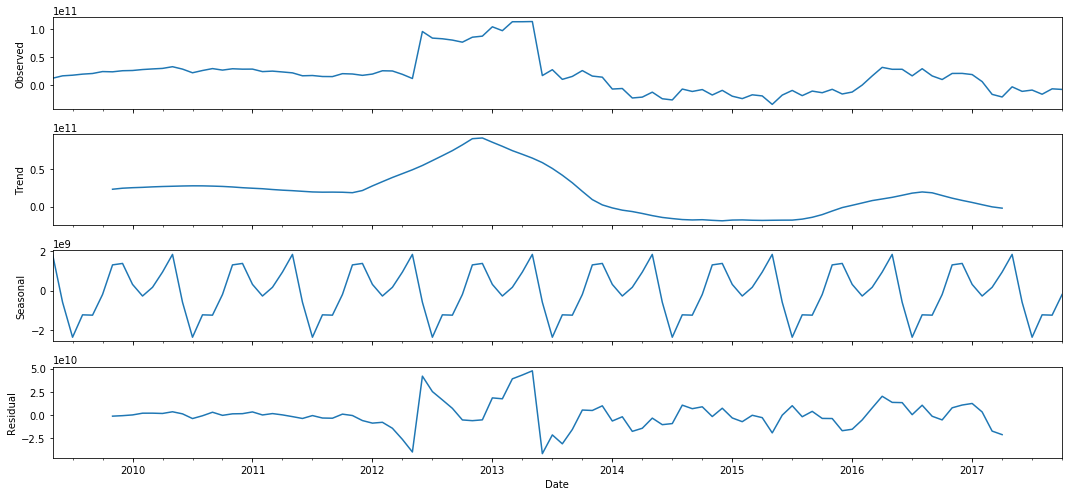

In [89]:
df['aud_box_diff'] = df.aud_box - df.aud_box.shift(12)
sm.tsa.seasonal_decompose(df.aud_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.aud_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.012501


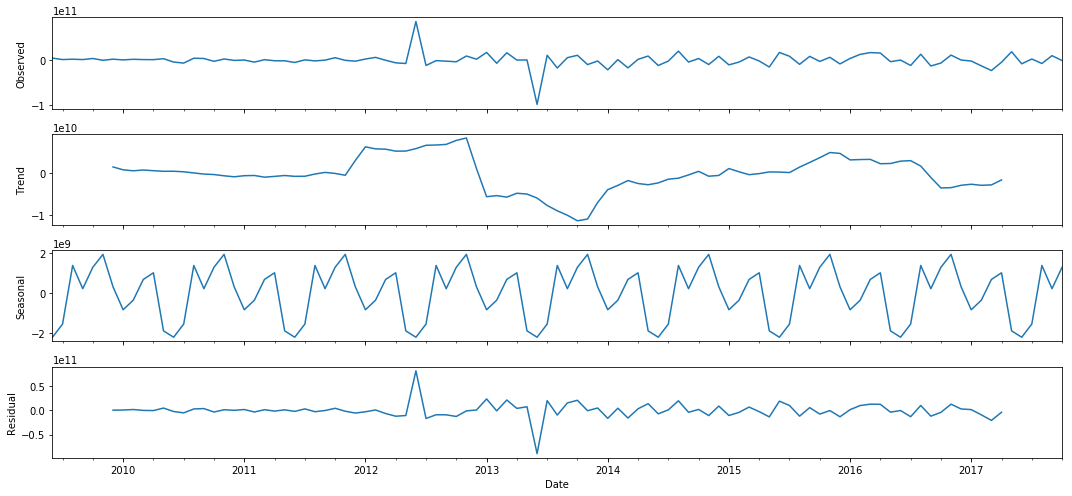

In [90]:
df['aud_box_diff2'] = df.aud_box_diff - df.aud_box_diff.shift(1)
sm.tsa.seasonal_decompose(df.aud_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.aud_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

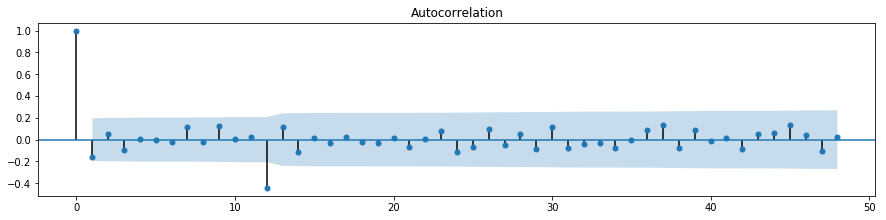

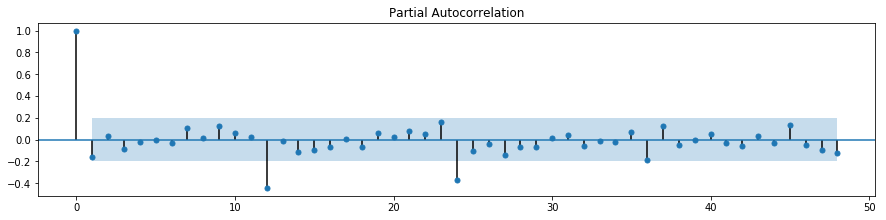

In [91]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.aud_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.aud_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [92]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [93]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [94]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.aud_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
Wall time: 42.4 s


In [95]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
0   (0, 0, 0, 1)  4982.610457
2   (0, 0, 1, 1)  4984.546151
12  (1, 0, 0, 1)  4993.890961
4   (0, 1, 0, 1)  4995.171264
14  (1, 0, 1, 1)  4995.785344


Лучшая модель:

In [96]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            aud_box   No. Observations:                  114
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood               -2489.305
Date:                            Sat, 16 Dec 2017   AIC                           4982.610
Time:                                    04:39:03   BIC                           4988.083
Sample:                                05-01-2008   HQIC                          4984.831
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.8092      0.057    -14.228      0.000      -0.921      -0.698
sigma2      1.518e+20   3.19e-22   

C:\Users\AliceP\Anaconda3\lib\site-packages\numpy\linalg\linalg.py:1487: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


Критерий Стьюдента: p=0.752217
Критерий Дики-Фуллера: p=0.000000


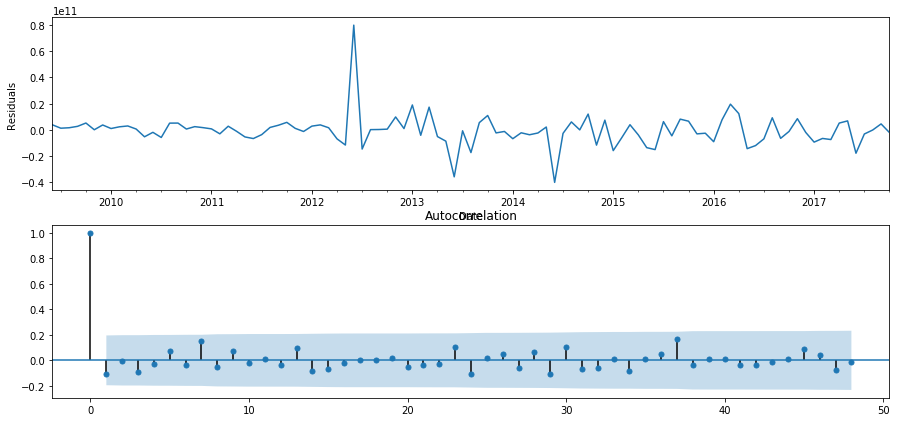

In [97]:
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

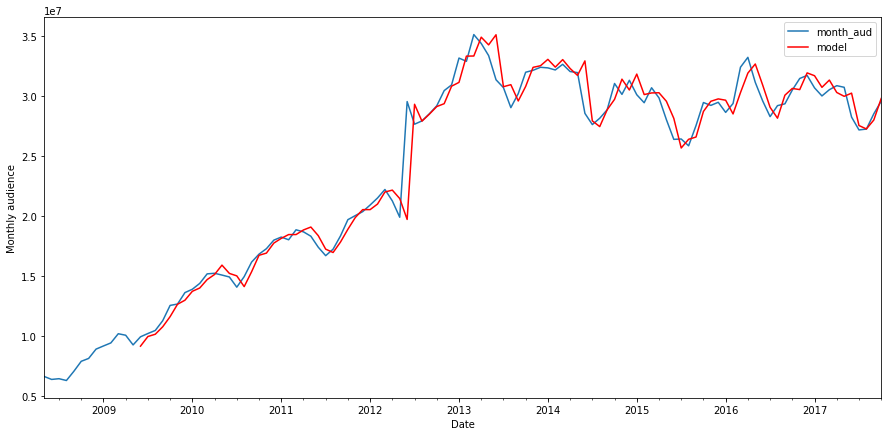

In [98]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
df.month_aud.plot()
df.model[13:].plot(color='r')
plt.ylabel('Monthly audience')
plt.legend()
pylab.show()

### Прогноз

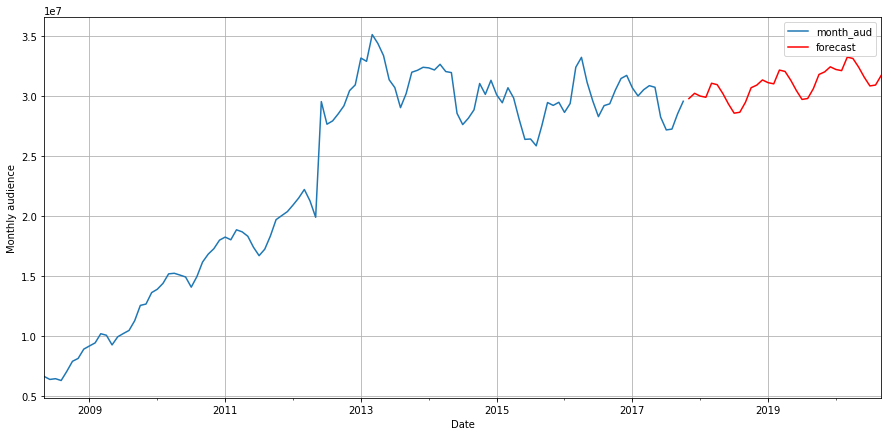

In [99]:
df2 = df[['month_aud']]
date_list = [datetime.datetime.strptime("2017-10-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=114, end=200), lmbda)

df.month_aud.plot()
a = df2.forecast
a.plot(color='r')
plt.ylabel('Monthly audience')
plt.grid('on')
plt.legend()
pylab.show()